<a href="https://colab.research.google.com/github/amyush/FrequencyDomain_Watermarking/blob/main/watermarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setting up the environment**

In [355]:
!git clone https://github.com/amyush/FrequencyDomain_Watermarking.git

fatal: destination path 'FrequencyDomain_Watermarking' already exists and is not an empty directory.


In [356]:
import numpy as np
import cv2
import math
import pywt
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from PIL import Image as im
import math
from scipy.fftpack import dct
from scipy.fftpack import idct
from google.colab.patches import cv2_imshow

# **Custom Functions**

In [357]:
def setParams():
    global sizeOrig 
    sizeOrig = 512
    global sizeWatermark
    sizeWatermark = 64
    global alpha 
    alpha = 0.02
    global betaFactor
    betaFactor = 1
    global imgPath
    imgPath = "FrequencyDomain_Watermarking/"
    global factor
    factor = sizeOrig // sizeWatermark

def stringToBinary(a):
  l=[]
  res = ''.join(format(ord(i), '08b') for i in a)
  return res

def calculatePSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                    # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def apply_dct(image_array):
    size = len(image_array[0])
    all_subdct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = image_array[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            all_subdct[i:i+8, j:j+8] = subdct

    return all_subdct

def inverse_dct(all_subdct):
    size = len(all_subdct[0])
    all_subidct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(all_subdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            all_subidct[i:i+8, j:j+8] = subidct

    return all_subidct

# **Steganography**

## **Hiding the data**

In [370]:
def encodingImage(imageName, key, hiddenImageName):
    setParams();
    binKey = stringToBinary(key)
    lenBinKey = len(binKey)
    
    # Reading the cover image
    originalImage = cv2.imread(imgPath + imageName)
    originalImage = cv2.resize(originalImage, (sizeOrig, sizeOrig))
    waterMarkedImage = originalImage
    waterMarkedImage = cv2.cvtColor(waterMarkedImage, cv2.COLOR_BGR2RGB)
    
    inputArray = np.array(waterMarkedImage[:,:,0], dtype=float)

    # Reading the watermark image
    waterMarkLogo = cv2.imread(imgPath + hiddenImageName)
    waterMarkLogo = cv2.resize(waterMarkLogo, (sizeWatermark,sizeWatermark))
    waterMarkArray = np.array(waterMarkLogo,dtype=float)
    flatWaterMark = (waterMarkArray/255).ravel()

    index = -1
    count = 0
    beta = betaFactor

    for i in range(0, sizeOrig, 8):
        for j in range(0, sizeOrig, 8):
            if((int)(binKey[index%lenBinKey]) == 1):
                beta *= -1
            inputArray[i:i+8,j:j+8]=dct(dct(inputArray[i:i+8,j:j+8].T, norm="ortho").T, norm="ortho")
            inputArray[1][1] += alpha * beta * flatWaterMark[count]
            inputArray[i:i+8,j:j+8]=idct(idct(inputArray[i:i+8,j:j+8].T, norm="ortho").T, norm="ortho")
            count += 1

    waterMarkedImage[:,:,0] = inputArray
    waterMarkedImage = np.array(waterMarkedImage).astype(np.uint8)
    waterMarkedImage = cv2.cvtColor(waterMarkedImage, cv2.COLOR_BGR2RGB)
    res = cv2.imwrite('watermarked11.jpg', waterMarkedImage)
    return originalImage, waterMarkedImage


## **Extracting the watermark image**

In [359]:
def extractImage(imageName, key):
    setParams();
    binKey = stringToBinary(key)
    lenBinKey = len(binKey)
    
    # Reading the cover image
    inputImage = Image.open(imgPath + imageName).convert('L')
    # Resizing the cover image so that it's dimension is compatible with the watermark image
    inputImage = inputImage.resize((sizeOrig,sizeOrig),Image.BILINEAR)
    # Converting the original image to array
    inputArray = np.array(inputImage.getdata(), dtype=np.float).reshape((sizeOrig,sizeOrig))

    # Reading the watermark image
    waterMarkImage = Image.open(imgPath + hiddenImageName).convert('L')
    # Resizing the logo image so that it's dimension is compatible with the cover image
    waterMarkImage = waterMarkImage.resize((sizeWatermark, sizeWatermark), Image.BILINEAR)
    waterMarkArray = np.array(waterMarkImage.getdata(), dtype=np.float).reshape((sizeWatermark,sizeWatermark))

    dctOrigArray = apply_dct(inputArray)
    dctWaterMarkArray = apply_dct(waterMarkArray)
    flatWaterMark = waterMarkArray.ravel()

    index = -1
    count = 0

    for x in range (0, dctOrigArray.shape[0], 16):
        for y in range (0, dctOrigArray.shape[1], 16):
            index = index + 1;
            if((int)(binKey[index%lenBinKey]) == 1):
                beta *= -1
            if count < flatWaterMark.size:
                subdct = dctOrigArray[x:x+16, y:y+16]
                subdct[12][12] = subdct[12][12] + alpha * beta * flatWaterMark[count]
                dctOrigArray[x:x+16, y:y+16] = subdct
                count += 1 
    
    idctArray = inverse_dct(dctOrigArray)
    resImage = cv2.imwrite('coverRes.png', idctArray)

# **Results**

PSNR value = 69.45912984350143


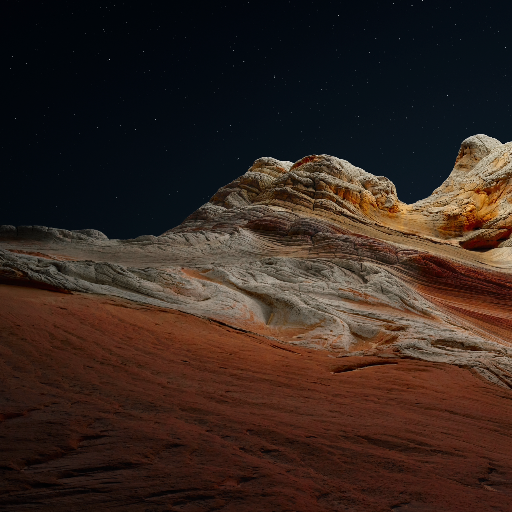

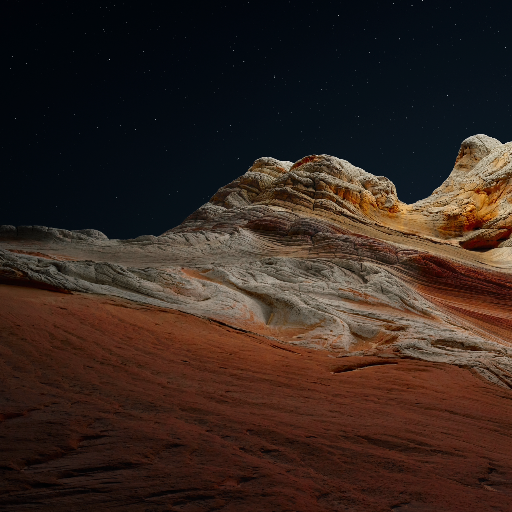

In [375]:
# coverFileName = input("Enter the cover filename: (eg- cover.jpg or lena.png)")
# key = input("Enter the key:")
# waterMarkImageName = input("Enter the name of the image to be hidden: (eg- iitbbs_logo.jpeg or logo.png)")

coverFileName = 'cover.jpg'
key = 'Appa'
hiddenImageName = 'iitbbs_logo.jpeg'

originalImage, waterMarkedImage = encodingImage(coverFileName, key, hiddenImageName)
psnr = calculatePSNR(originalImage, waterMarkedImage)
print('PSNR value = {}'.format(psnr))

cv2_imshow(originalImage)
cv2_imshow(waterMarkedImage)

In [361]:
# resImage = Image.open('watermarked1.jpg').convert('RGB')
resImage = water_marked
# inputImage = Image.open('FrequencyDomain_Watermarking/cover.jpg').convert('RGB')
inputImage = orig
# inputImage = inputImage.resize((sizeOrig, sizeOrig), Image.BILINEAR)
psnr = calculatePSNR(inputImage, resImage)
print(psnr)

# plt.subplot(1,2,1),plt.imshow(inputImage.convert('RGB')), plt.title("Input Image")
# plt.subplot(1,2,2),plt.imshow(resImage.convert('RGB')), plt.title("Output Image") 


71.29072243984514


In [363]:
# waterMarkedImage = 'coverRes.jpg'
# key = 'Appa'

# extractImage(waterMarkedImage, key)